In [36]:
def text_detection_full_response(path):
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    return response

In [37]:
def strip_menu(response):
    
    # remove these chars from entry
    chars_to_remove = '0123456789!"\'#$%&()*+,-./:;<=>?@[\]^_`{|}~♦●★‒…£¡™¢∞§¶•ªº–≠≠œ∑´®†¥¨≤≥÷ç√€'

    # remove entry if it exactly matches any of these
    drop_exact_words = ['sandwiches','restaurant','menu',
                        'restaurant menu','thank you','drinks',
                        'appetizer','appetizers','mains','dessert',
                        'side','sides','side order','breakfast','lunch'
                       'dinner','supper','starter','starters','local',
                        'fresh','food','main','your','logo','brand name']
    
    # remove these words from entry
    words_to_remove = ['menu','restaurant','price','appetizer',
                       'appetizers','course','price','extra','extras']

    # remove entry if it contains any of these
    drop_contain_words = ['tax','consumer','advisory','illness','facebook','instagram']
    
    # remove entry if it starts with any of these
    drop_start_words = ['add','include','includes','including','lorem','with','and',
                       'served','serve']
    
    # drop entry if it contains fewer chars than minimum
    min_length = 4
    
    
    text = response.text_annotations[0].description
    menu_original = text.split('\n')
    
    menu_chars_removed = []
    for item in menu_original:
        for char in chars_to_remove:
            item = item.replace(char,' ')
        menu_chars_removed.append(item)
        
    menu_exact_matches_dropped = []
    for item in menu_chars_removed:
        if item.lower() in drop_exact_words:
            pass
        else:
            menu_exact_matches_dropped.append(item)
        
    menu_words_removed = []
    for item in menu_exact_matches_dropped:
        temporary = []
        for word in item.split(' '):
            if word.lower() not in words_to_remove:
                temporary.append(word)
        remaining_words = ' '.join(temporary)
        menu_words_removed.append(remaining_words)
             
    menu_contains_dropped = []
    for item in menu_words_removed:
        temporary = []
        for word in item.split(' '):
            if word.lower() in drop_contain_words:
                temporary = []
                pass
            else:
                temporary.append(word)
        remaining_words = ' '.join(temporary)
        menu_contains_dropped.append(remaining_words)

    menu_starts_dropped = []
    for item in menu_contains_dropped:
        temporary = item.split(' ')
        if temporary[0].lower() in drop_start_words:
            pass
        else:
            menu_starts_dropped.append(item)
    
    menu_exact_matches_dropped = []
    for item in menu_starts_dropped:
        if item.lower() in drop_exact_words:
            pass
        else:
            menu_exact_matches_dropped.append(item)
            
    bounding_white_space_removed = [item.strip() for item in menu_exact_matches_dropped]
    too_short_dropped = [item for item in bounding_white_space_removed if len(item) >= min_length]
    
    duplicates_dropped = []
    for item in too_short_dropped:
        if item not in duplicates_dropped:
            duplicates_dropped.append(item)

    
    stripped_menu = duplicates_dropped
    
    print('original menu:')
    print()
    print(menu_original)
    print()
    print('stripped menu:')
    print()
    print(stripped_menu)
    print()
    return(stripped_menu)

In [38]:
def optimized_image_fetch_and_check(query):
    import os
    from dotenv import load_dotenv, find_dotenv
    from google_images_search import GoogleImagesSearch
    from google.cloud import vision

    env_path = find_dotenv()
    load_dotenv(env_path)
    
    GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
    GOOGLE_CX = os.getenv('GOOGLE_CX')
    
    print(f'searching for {query}...')
    print()

    gis = GoogleImagesSearch(GOOGLE_API_KEY,GOOGLE_CX)
    
    _search_params = {
    'q': f'{query} recipe',
    'num': 1,
    #'imgSize': 'large',
    'imgType': 'photo',
    'imgColorType': 'color'}
    
    gis.search(search_params=_search_params)
    print('fetching image:')
    if len(gis.results()) == 0:
        print('no image found, not verified as food.')
        print()
        return None
    
    url = gis.results()[0].url
    print(url)
    print()
    
    verified_queries = ['cheeseburger','burger','pizza','fried chicken','ice cream sundae','fuyung hai']
    
    if query.lower() in verified_queries:
        print(f'{query} already in known foods database, no need to verify!')
        print()
        return url
    
    client = vision.ImageAnnotatorClient()
    image = vision.Image()
    image.source.image_uri = url
    
    response = client.label_detection(image=image, max_results=1)
    label = [lab.description for lab in response.label_annotations]
    score = [lab.score for lab in response.label_annotations]
    
    text_response = client.text_detection(image=image)
    texts = text_response.text_annotations
    n_chars = 0
    if len(texts)>0:
        n_chars = len(texts[0].description)
    
    print('verification filter:')
    print('label must be Food or Tableware')
    print('score must be above .96')
    print('number of chars must be below 100')
    print()
    print(f'label: {label}')
    print(f'label score: {score}')
    print(f'chars detected: {n_chars}')
    print()
    
    try:
        if (label[0] == 'Food' or label[0] == 'Tableware') and score[0] > .96 and n_chars < 100:
            print('verified as food!')
            print()
            print(url)
            print()
            return url
    except IndexError:
        print('label missing, not verified as food')
        pass
    

    _search_params = {
    'q': f'{query} recipe',
    'num': 3,
    #'imgSize': 'large',
    'imgType': 'photo',
    'imgColorType': 'color',
    'safe': 'medium'}
        
    gis = GoogleImagesSearch(GOOGLE_API_KEY,GOOGLE_CX)
    gis.search(search_params=_search_params)
    urls = [result.url for result in gis.results()]
    print('fetching additional images:')
    if len(urls)<=1:
        print('no additional images found, not verified as food')
        return None
    urls = urls[1:]
    for url in urls:
        print(url)
    print()
    
    labels = []
    scores = []
    char_counts = [] 
    for url in urls:
        
        image.source.image_uri = url
        response = client.label_detection(image=image, max_results=1)
        label = [lab.description for lab in response.label_annotations]
        score = [lab.score for lab in response.label_annotations]
        labels.append(label)
        scores.append(score)
        
        text_response = client.text_detection(image=image)
        texts = text_response.text_annotations
        n_chars = 0
        if len(texts)>0:
            n_chars = len(texts[0].description)
        char_counts.append(n_chars)
        
    print(f'labels: {labels}')
    print(f'label scores: {scores}')
    print(f'chars detected: {char_counts}')
    print()

    for label,score,n_chars in zip(labels,scores, char_counts):
        try:
            if (label[0] == 'Food' or label[0] == 'Tableware') and score[0] > .96 and n_chars < 100:
                print('verified as food!')
                print()
                print(urls[labels.index(label)])
                print()
                return urls[labels.index(label)]
        except:
            pass
        
    print('not verified as food.')
    print()
    return None

In [39]:
def detect_text_boxes(response):
    
    import pandas as pd
    
    texts = response.text_annotations

    text_list = []
    top_left = []
    top_right = []
    bottom_left = []
    bottom_right = []


    for text in texts[1:]:
        new_text = '''{}'''.format(text.description)
        text_list.append(new_text)
        
        vertices = [tuple((vertex.x, vertex.y)) for vertex in text.bounding_poly.vertices]

        new_bounding = vertices

        top_left.append(vertices[0])
        top_right.append(vertices[1])
        bottom_left.append(vertices[3])
        bottom_right.append(vertices[2])
        
    detected_df = pd.DataFrame({
        'text': text_list,
        'top_left': top_left,
        'top_right': top_right,
        'bottom_left': bottom_left,
        'bottom_right': bottom_right
    })

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))


    return detected_df


In [40]:
def get_url_dict(stripped_menu):
    url_dict = {}
    for menu_item in stripped_menu:
        url = optimized_image_fetch_and_check(menu_item)
        if url is not None:
            url_dict[menu_item] = url
    return url_dict

In [41]:
def map_text_boxes(detected_df, url_dict):
    from itertools import combinations
    import pandas as pd
    from statistics import stdev
    import string

    test_menu_df = detected_df

    split_keys = []
    for key in url_dict.keys():
        split_keys.append(key.split())

    temp_dfs = []
    for key_set in split_keys:
        temp_df = pd.DataFrame()
        for key in key_set:
            mask = test_menu_df['text'] == key
            temp_df = pd.concat([temp_df, test_menu_df[mask]])
            temp_df = temp_df.drop_duplicates()
        temp_df['position'] = temp_df['bottom_left'] 

        word_positions = list(zip(temp_df.text, temp_df.position))
        combos = []

        for combo in list(combinations(word_positions, len(key_set))): 
            text_portion = [pair[0] for pair in combo]
            if len(set(text_portion)) == len(key_set):
                combos.append(combo)
        calc_df = pd.DataFrame(combos)

        position_stds = []
        for combo in combos:
            position = [pair[1] for pair in combo]
            if len(position) >= 2:
                calc_nums = [pair[1] for pair in position]
                position_stds.append(stdev(calc_nums))
            else:
                position_stds.append(0)
        calc_df['position_stds'] = position_stds
        calc_df = calc_df.sort_values(by=['position_stds'])

        if len(calc_df) > 0:
            calc_df = calc_df.iloc[[0]]

        keep = []
        keep_text = []
        keep_pos = []
        for column in calc_df:
            if column != 'position_stds':
                keep.append(calc_df[column].to_string(index=False))
        for item in keep:
            pair = item.split(', ')
            temp_text = [char for char in pair[0] if char not in '[](),']
            temp_pos = [char for char in pair[1:]]
            temp_pos = str(temp_pos)
            temp_pos = [char for char in temp_pos if char in string.digits or char not in string.punctuation]
            temp_text = ''.join(temp_text)
            temp_pos = ''.join(temp_pos)
            temp_pos = temp_pos.split(' ')
            temp_pos = [int(n) for n in temp_pos]
            temp_pos = tuple(temp_pos)

            keep_text.append(''.join(temp_text))
            keep_pos.append(temp_pos)

        merge_df = pd.DataFrame()
        for text,pos in zip(keep_text,keep_pos):
            merge_df = pd.concat([merge_df, pd.DataFrame({'text': [text],
                                    'top_left': [None],
                                    'top_right': [None],
                                    'bottom_left': [None],
                                    'bottom_right': [None],
                                    'position': [pos]})], ignore_index=False)
        temp_df = pd.concat([temp_df,merge_df],ignore_index=False)
        if None in temp_df['top_left'].values:
            temp_df = temp_df.loc[temp_df.duplicated(subset='position', keep=False)]
        temp_df = temp_df.dropna()

        for index in temp_df.index:
            if index in test_menu_df.index:
                test_menu_df = test_menu_df.drop(index)
        temp_dfs.append(temp_df)
        
    box_dict = {}

    for i, key in enumerate(url_dict.keys()):
        try:
            box_dict[key] = [temp_dfs[i].iloc[0]['top_left'],
                     temp_dfs[i].iloc[-1]['bottom_right']]
        except IndexError:
            pass
        
    return box_dict

In [42]:
def show_text_boxes(path, box_dict):
    import io
    from matplotlib import pyplot as plt
    from matplotlib import patches as pch
    
    
    a = plt.imread(path)
    fig, ax = plt.subplots(1)
    ax.imshow(a)
    
    for value in box_dict.values():
        rect = pch.Rectangle(value[0], 
                            abs(value[0][0]-value[-1][0]), abs(value[0][1]-value[-1][1]), 
                            linewidth = 1, edgecolor ='r', facecolor ='none') 
        ax.add_patch(rect)


original menu:

['LOADED BAKED POTATO........', 'ROASTED VEGETABLES', 'PEACH & BLACKBERRY COBBLE', 'STRAWBERRY CAKE', '....... 12', '...... 15', '...... 5$', '.....7$']

stripped menu:

['LOADED BAKED POTATO', 'ROASTED VEGETABLES', 'PEACH   BLACKBERRY COBBLE', 'STRAWBERRY CAKE']

searching for LOADED BAKED POTATO...

fetching image:
https://hips.hearstapps.com/delish/assets/15/38/1442259703-country-crock-stuffed-potatoes.jpg

verification filter:
label must be Food or Tableware
score must be above .96
number of chars must be below 100

label: ['Food']
label score: [0.9829522371292114]
chars detected: 2

verified as food!

https://hips.hearstapps.com/delish/assets/15/38/1442259703-country-crock-stuffed-potatoes.jpg

searching for ROASTED VEGETABLES...

fetching image:
https://s23209.pcdn.co/wp-content/uploads/2014/10/Roasted-VegetablesIMG_0415-760x1140.jpg

verification filter:
label must be Food or Tableware
score must be above .96
number of chars must be below 100

label: ['Food']
lab

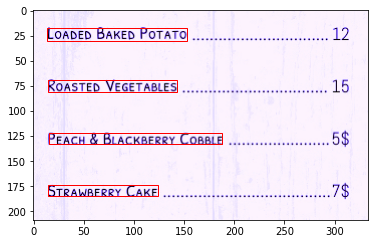

In [43]:
# testing it all out together 

path = '../raw_data/all_menus/english_menu_9.jpg'

response = text_detection_full_response(path)
stripped_menu = strip_menu(response)
detected_df = detect_text_boxes(response)
url_dict = get_url_dict(stripped_menu)
box_dict = map_text_boxes(detected_df, url_dict)
show_text_boxes(path, box_dict)